In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_core.runnables import RunnableConfig
from dataclasses import dataclass
from langchain_core.messages import AnyMessage, AIMessage   

### State and Schema

In [3]:
class InputState(TypedDict):
    user_input: str

class OutputState(TypedDict):
    final_ans: str

class PrivateState(TypedDict):
    dummy_state_value: str

class OverallState(TypedDict):
    middle_value: str
    user_input: str
    # final_ans: str


def node_1(state: InputState) -> OverallState:
    return {"middle_value": "dummy middle value"}

def node_2(state: OverallState) -> PrivateState:
    return {"dummy_state_value": f"user_input: {state['user_input']}, middle_value: {state['middle_value']}"}

def node_3(state: PrivateState) -> OutputState:
    return {"final_ans": f"{state['dummy_state_value']}"}
    

builder = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

graph = builder.compile(name="demo_graph")

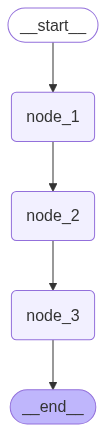

In [4]:
graph

In [5]:
graph.invoke({"user_input":"My"})


{'final_ans': 'user_input: My, middle_value: dummy middle value'}

### Reducer functions, CachePolicy, RetryPolicy

In [5]:
# with reducer function
from operator import add
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState

class State(TypedDict):
    messages: Annotated[list[str], add]
    extra_field: int

class GraphState(TypedDict):
    documents: Annotated[list[AnyMessage], add_messages]

class State(MessagesState):
    documents: list[str]

In [7]:
# use caching 
from langgraph.types import CachePolicy, RetryPolicy
import time
from langgraph.cache.memory import InMemoryCache

class State(TypedDict):
    messages: int
    constant: int

def expensive_node(state: State):
    time.sleep(1)
    return {"messages": state["messages"]}

builder = StateGraph(State).add_node("expensive_node", expensive_node, cache_policy=CachePolicy(ttl=3), retry_policy=RetryPolicy())

builder.set_entry_point("expensive_node")
builder.set_finish_point("expensive_node")

graph = builder.compile(cache=InMemoryCache())

print(graph.invoke({"messages": 5}, stream_mode='updates'))  
# if time.sleep(3) then cached result is not use
time.sleep(2)
print(graph.invoke({"messages": 5}, stream_mode='updates'))  


[{'expensive_node': {'messages': 5}}]
[{'expensive_node': {'messages': 5}, '__metadata__': {'cached': True}}]


In [7]:
class State(MessagesState):
    documents: Annotated[list[AnyMessage], add]

def node_1(state: State):
    state['documents'] = AIMessage("Hello")
    return {"documents": [state["documents"]]}

def node_2(state: State):
    state['documents'] = AIMessage("Hello2")
    return {"documents": [state["documents"]]}

builder = StateGraph(State).add_node("node_1", node_1).add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

graph = builder.compile()

graph.invoke({"documents": ["sp"]})
graph.invoke({"documents": ["sp1"]})

{'messages': [],
 'documents': ['sp1',
  AIMessage(content='Hello', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Hello2', additional_kwargs={}, response_metadata={})]}

In [8]:
# run node in parallel
import operator

class State(TypedDict):
    messages: Annotated[list[str], add]

def node_1(state:State):
    print(f"Node-1 : {state['messages']}")
    return {"messages": ["A"]}

def node_2(state:State):
    print(f"Node-2 : {state['messages']}")
    return {"messages": ["B"]}

def node_3(state:State):
    print(f"Node-3 : {state['messages']}")
    return {"messages": ["C"]}

def node_4(state:State):
    print(f"Node-3 : {state['messages']}")
    return {"messages": ["D"]}

builder = StateGraph(State).add_node("node_1", node_1).add_node("node_2", node_2).add_node("node_3", node_3).add_node("node_4", node_4, defer=True)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", "node_4")
builder.add_edge("node_3", "node_4")
builder.add_edge("node_4", END)


graph = builder.compile()

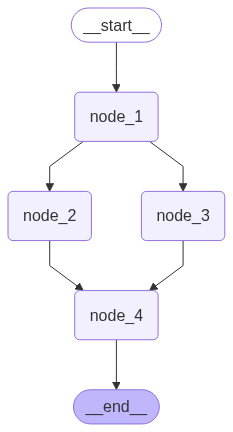

In [9]:
graph

In [10]:
graph.invoke({"messages": []})

Node-1 : []
Node-2 : ['A']
Node-3 : ['A']
Node-3 : ['A', 'B', 'C']


{'messages': ['A', 'B', 'C', 'D']}

In [11]:
# for defer node execution => previous all node is execute and then execute next node
# builder.add_node(d, defer=True)

In [10]:
from typing import Annotated, Literal
from operator import add

class State(TypedDict):
    messages: Annotated[list[str], add]
    which: str

def node_1(state: State):
    print(f"Node-1 : {state['messages']}")
    return {"messages": ["node-1"], "which": state["which"]}

def node_2(state: State):
    print(f"Node-2 : {state['messages']}")
    return {"messages": ["node-2"]}

def node_3(state: State):
    print(f"Node-3 : {state['messages']}")
    return {"messages": ["node-3"]}

builder = StateGraph(State).add_node("node_1", node_1).add_node("node_2", node_2).add_node("node_3", node_3)
builder.add_edge(START, "node_1")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

def conditional_edge(state: State) -> Literal["node_2", "node_3"]:
    return state["which"]
builder.add_conditional_edges("node_1", conditional_edge)

graph = builder.compile()

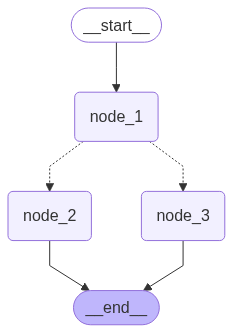

In [11]:
graph

In [13]:
graph.invoke({"messages":[], "which":"node_2"})

Node-1 : []
Node-2 : ['node-1']


{'messages': ['node-1', 'node-2'], 'which': 'node_2'}

In [15]:
# send func use for map-reduce, batch llm calles, scalable pipelines, parallel execution

import random
from langgraph.types import Send

def custom_dict_merge(dict1: dict, dict2: dict) -> dict:
    return dict1 | dict2

class State(TypedDict):
    total_num: int
    num_list: list
    num: int
    tables: Annotated[dict[int, list[int]], custom_dict_merge]
    max_num: int

def generate_num(state: State):
    num_list = [random.randint(1,100) for x in range(state["total_num"])]
    print(f"Generate_num: {num_list}")
    return {"num_list": num_list}

def continue_table(state: State) -> list[Send]:
    return [Send("create_table", {"num": i}) for i in state["num_list"]]

def create_table(state: State):
    tmp_table = [x*int(state["num"]) for x in range(11)]
    print(f"{state['num']} => {tmp_table}")
    return {"tables": {state['num']:tmp_table}}

def find_max_table(state: State):
    tmp_table_list = state["tables"]
    tmp = {key:sum(value) for key, value in tmp_table_list.items()}
    max_key = max(tmp, key=tmp.get)
    print(f"max key: {max_key}")
    return {"max_num": max_key}

builder = StateGraph(State).add_node("generate_num", generate_num).add_node("create_table", create_table).add_node("find_max_table", find_max_table)

builder.add_edge(START, "generate_num")
builder.add_conditional_edges("generate_num", continue_table, ["create_table"])
builder.add_edge("create_table", "find_max_table")
builder.add_edge("find_max_table", END)
builder.add_edge("generate_num", END)

graph = builder.compile()


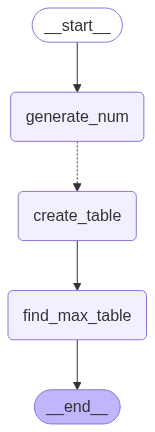

In [16]:
graph

In [17]:
graph.invoke({"total_num": 2})

Generate_num: [59, 64]
59 => [0, 59, 118, 177, 236, 295, 354, 413, 472, 531, 590]
64 => [0, 64, 128, 192, 256, 320, 384, 448, 512, 576, 640]
max key: 64


{'total_num': 2,
 'num_list': [59, 64],
 'tables': {59: [0, 59, 118, 177, 236, 295, 354, 413, 472, 531, 590],
  64: [0, 64, 128, 192, 256, 320, 384, 448, 512, 576, 640]},
 'max_num': 64}

In [15]:
from typing import Annotated, Literal
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    messages: Annotated[list[str], add]

def node_1(state: State):
    print(f'Node-1: {state["messages"]}')
    return {"messages": ["A"]}

def node_2(state: State):
    print(f'Node-2: {state["messages"]}')
    return {"messages": ["B"]}

def route(state: State) -> Literal[END, "node_2"]:
    if len(state["messages"]) > 8:
        return END
    else:
        return "node_2"


builder = StateGraph(State).add_node("node_1", node_1).add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", route)
builder.add_edge("node_2", "node_1")
# builder.add_edge("node_1", END)

graph = builder.compile()

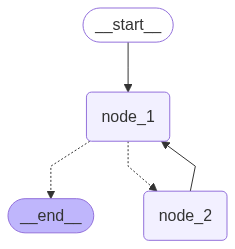

In [16]:
graph

In [23]:
from langgraph.errors import GraphRecursionError

# graph.invoke({"messages":[]})
try:
    graph.invoke({"messages":[]}, {"recursion_limit": 9})
except GraphRecursionError as e:
    print(e)

Node-1: []
Node-2: ['A']
Node-1: ['A', 'B']
Node-2: ['A', 'B', 'A']
Node-1: ['A', 'B', 'A', 'B']
Node-2: ['A', 'B', 'A', 'B', 'A']
Node-1: ['A', 'B', 'A', 'B', 'A', 'B']
Node-2: ['A', 'B', 'A', 'B', 'A', 'B', 'A']
Node-1: ['A', 'B', 'A', 'B', 'A', 'B', 'A', 'B']
Recursion limit of 9 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


In [27]:
# use Command use for stateful branching, multi-agent,  handoff
from langgraph.types import Command
import random

class State(TypedDict):
    messages: list[str]

def node_1(state: State):
    choise = random.choices(["node_2", "node_3"])
    print(f"random choise: {choise}")
    return Command(
        update={"messages": [choise]},
        goto=choise
    )

def node_2(state: State):
    print("Node_2 execute")
    return {"messages": ["node_2"]}

def node_3(state: State):
    print("Node_3 execute")
    return {"messages": ["node_3"]}

builder = StateGraph(State).add_node("node_1", node_1).add_node('node_2', node_2).add_node("node_3", node_3)
builder.set_entry_point("node_1")
graph = builder.compile()

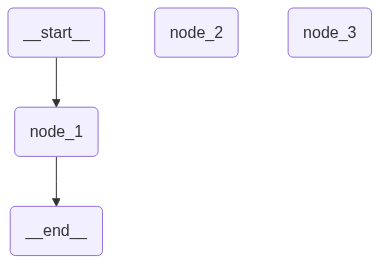

In [28]:
graph

In [53]:
graph.invoke({"messages":[]})

random choise: ['node_3']
Node_3 execute


{'messages': ['node_3']}

In [ ]:
class demo_config(TypedDict):
    demo_config: str

class State(TypedDict):
    messages: list[AnyMessage]
    extra_field: int

def call_llm(state: State):
    message = state["messages"]
    answer = AIMessage("Hello")
    return {"messages": message + [answer], "extra_field": 10}

builder = StateGraph(State, config_schema=demo_config).add_node("llm", call_llm)
builder.add_edge(START, "llm")
builder.add_edge("llm", END)

graph = builder.compile()

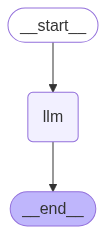

In [81]:
graph

In [82]:
from langchain_core.messages import HumanMessage

result = graph.invoke({"messages": [HumanMessage("Hi")]})
result

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Hello', additional_kwargs={}, response_metadata={})],
 'extra_field': 10}